# HW3

In [116]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings
import seaborn as sns

plt.style.use('seaborn')
sns.set_palette('cubehelix')

plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams['figure.dpi'] = 150
warnings.simplefilter(action='ignore', category=FutureWarning)

In [117]:
#!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

In [118]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [119]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [132]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS



<bound method NDFrame.head of Date
2018-01-03    0.031968
2018-01-04    0.033700
2018-01-05    0.028669
2018-01-08    0.003337
2018-01-09    0.001408
                ...   
2018-12-21   -0.089611
2018-12-24   -0.097990
2018-12-26    0.174243
2018-12-27    0.021132
2018-12-28   -0.013887
Length: 249, dtype: float64>

In [121]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))

weights /= np.sum(weights, axis=1)[:,np.newaxis] 

In [122]:
portf_rtns = np.dot(weights,avg_returns)

portf_vol = []
for i in range(0, len(weights)): 
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
  

portf_vol = np.array(portf_vol) 
portf_sharpe_ratio = portf_rtns / portf_vol 

In [123]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

In [124]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
         indices_to_skip.append(point_index) 
         continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

In [125]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind] 

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

## Maximum Sharpe Ratio portfolio weights

---



In [126]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

### AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

## Minimum Volatility portfolio weights

In [127]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

### AAPL: 28.08% IBM: 58.69% MSFT: 13.22%

# HW4

1. Maximum Sharpe Ratio portfolio
weights - AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

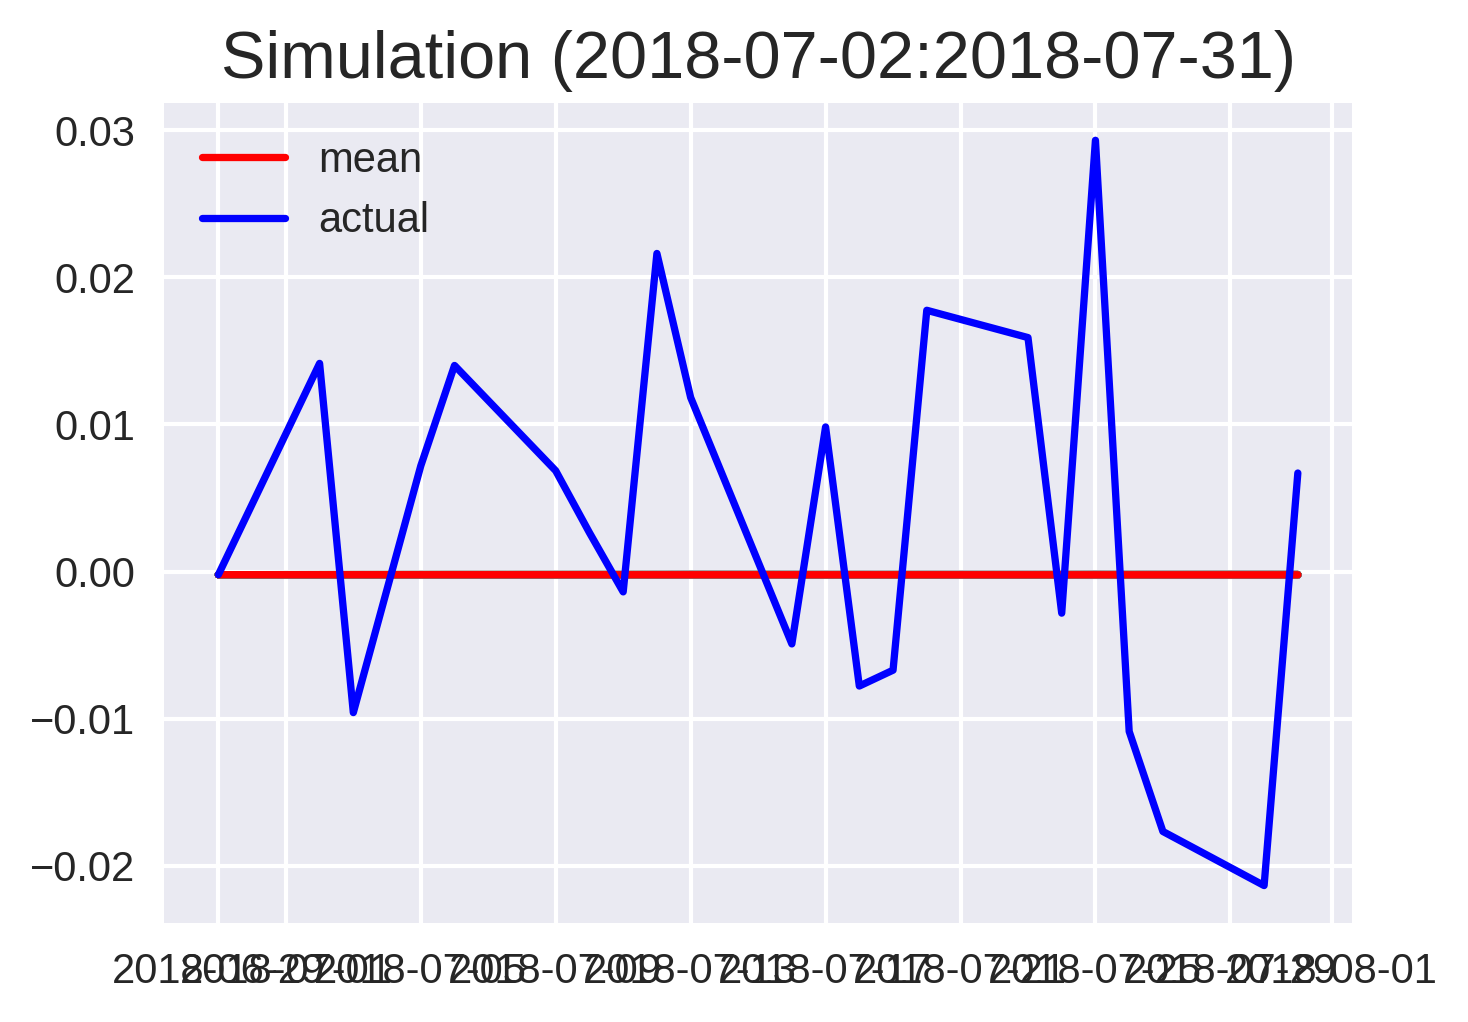

In [136]:
'''
returns_port = returns_df['AAPL']*0.0019 + returns_df['IBM']*0.0029 + returns_df['MSFT']*0.9952

train = returns_port['2018-01-01':'2018-06-30']
test = returns_port['2018-07-01':'2018-07-31']

T = len(test)
N = len(test) 
s_0 = returns_port[train.index[-1]]
N_SIM = 100 
mu = train.mean()
sigma = train.std()

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = returns_port[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, returns_port[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()

plt.show()

'''

2. Minimum Volatility portfolio
weights - AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

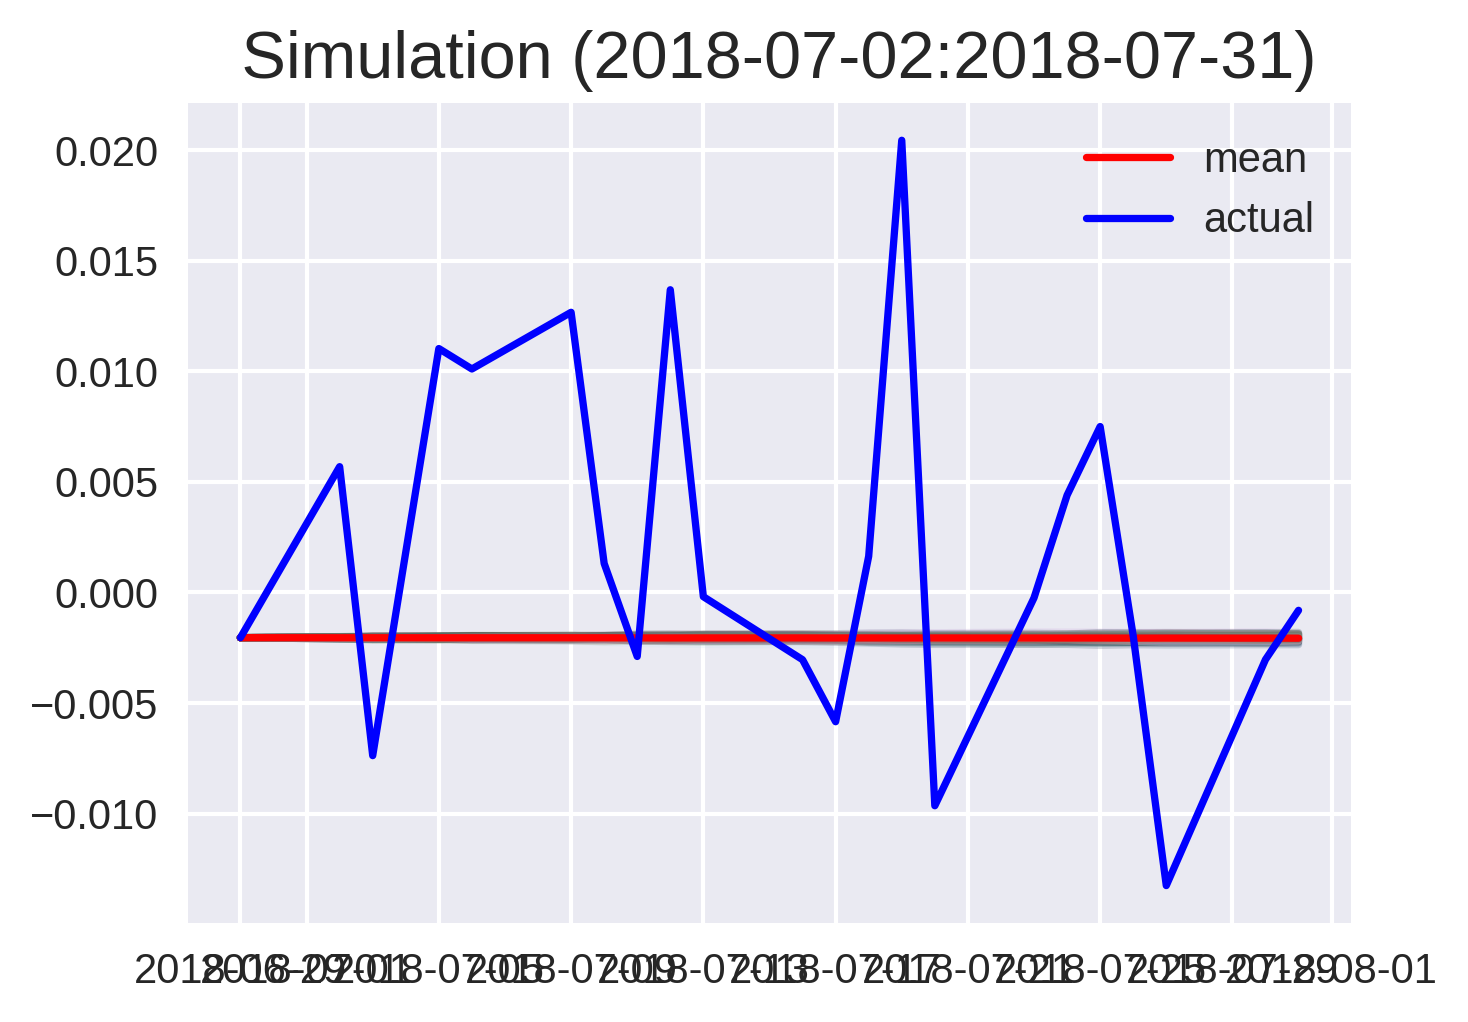

In [137]:
'''
returns_port = returns_df['AAPL']*0.2808 + returns_df['IBM']*0.5869 + returns_df['MSFT']*0.1322

train = returns_port['2018-01-01':'2018-06-30']
test = returns_port['2018-07-01':'2018-07-31']

T = len(test)
N = len(test) 
s_0 = returns_port[train.index[-1]]
N_SIM = 100 
mu = train.mean()
sigma = train.std()

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):

    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f' Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = returns_port[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, returns_port[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()

plt.show()
'''